In [1]:
import jax.numpy as jnp



In [2]:
def make_discrete_laplacian(size, dt):
    return -(jnp.eye(size)*2 + jnp.eye(size, k=1) + jnp.eye(size, k=-1))/(dt**2)

(1, 1)


Array([0.82509947], dtype=float32)

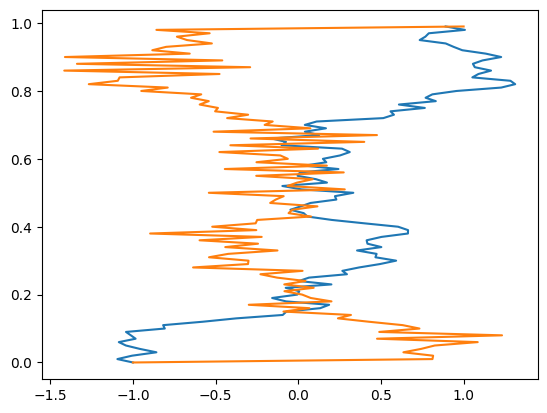

In [ ]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import numpy as np

from path_sampling import make_double_well_potential, sample_sde

key = jax.random.key(0)

hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 1000}

time = np.arange(0,hyperparams['num_steps'])*hyperparams['dt']

ndims = 1

## draw an initial path
brownian_bridge_drift = lambda x,t: (1 - x)/(1-t)
path_key = jax.random.key(1)
xs, times = jax.pmap(lambda key:sample_sde(
    b=brownian_bridge_drift, 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    rho = lambda key: jnp.zeros((ndims,))-1.,
    key=key, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(path_key, 1))


## a double well potential
u = lambda x: -jax.grad(make_double_well_potential(v=5.0))(x)

## a single step of the mcmc integration
def step(xts, u, key, ds, hyperparams):
    dt = hyperparams['dt']
    discrete_laplacian = make_discrete_laplacian(hyperparams['num_steps'], dt)

    I = jnp.eye(hyperparams['num_steps'])
    L = (I - 0.25*ds*discrete_laplacian)
    R = (I + 0.25*ds*discrete_laplacian)
    L_inv = jnp.linalg.inv(L)

    jacobian_u = jax.jacfwd(u)

    M_part_1 = -0.5*ds*jax.vmap(lambda k: jacobian_u(k) @ u(k))(xts)
    M_part_2 = -0.5*ds*jax.vmap(jax.grad(lambda k: jnp.trace(jacobian_u(k))) )(xts)

    noise = jnp.sqrt(2 * (ds/dt))*jax.random.normal(key, shape=xts.shape)

    xts_ds = L_inv @ (R @ xts + M_part_1 + M_part_2 + noise)
    xts_ds = xts_ds.at[0].set(-1)
    xts_ds = xts_ds.at[-1].set(1)
    return xts_ds

def spde_integrator(xts, u, num_steps, key, ds, hyperparams):

    for i in range(num_steps):
        key = jax.random.fold_in(key, i)
        xts = step(
            xts=xts,
            u=u,
            key=key,
            ds=ds,
            hyperparams=hyperparams
        )

    return xts
    
xts = spde_integrator(
    xts=xs[0],
    u=u,
    num_steps=1,
    key=jax.random.key(0),
    ds=0.001,
    hyperparams=hyperparams
)

# # plot xs[0]
plt.plot(xs[0], time, label='sampled')
plt.plot(xts, time, label='sampled')
xts[5]



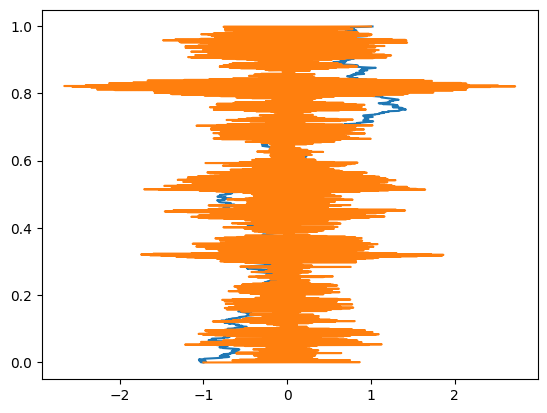

In [45]:

f = lambda x: (x*((8/((1 + x**2)**2)) - 2))

hyperparams = {'dt': 1e-2, 'num_steps': 1000, 'num_training_steps' : 1000}
ds = hyperparams['dt']**2

brownian_bridge_drift = lambda x,t: (1 - x)/(1-t)
path_key = jax.random.key(1)
xs, times = jax.pmap(lambda key:sample_sde(
    b=brownian_bridge_drift, 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    # rho = lambda key: jax.random.normal(key, shape=(ndims,))-2,
    rho = lambda key: jnp.zeros((ndims,))-1.,
    key=key, 
    dt=hyperparams['dt']/10, 
    num_steps=hyperparams['num_steps']))(jax.random.split(path_key, 1))



xts = spde_integrator(
    xts=xs[0],
    u=f,
    num_steps=1000,
    key=jax.random.key(0),
    ds=0.0001,
    hyperparams=hyperparams
)

plt.plot(xs[0], times[0], label='sampled')
plt.plot(xts, times[0], label='sampled')
